# covarying neighborhood analysis: a demo

This notebook demonstrates the basic use of the `rcna` R package. Before you run it, make sure you either install `rcna` by running `devtools::install_github('korsunskylab/rcna')`. This demo mirrors the demo of the original cna python package by Reshef and Rumker: 

- code: https://github.com/yakirr/cna
- paper: https://www.biorxiv.org/content/10.1101/2021.04.19.440534v2



In [2]:
library(rcna)
library(ggplot2)
library(patchwork)

## 1. minimal working example

Let's first see how to run `cna` and visualize results for a dataset that's already been appropriately prepared. You can learn more about data pre-processing and formatting in Section 2.

In [3]:
data('rcna_demo')

In [2]:
# read in toy dataset
data('rcna_demo')
d <- rcna_demo

# perform association test for case/ctrl status, controlling for sex as a covariate and accounting for potential batch effect
res <- association(
    data = d,                                   #dataset
    y = d$samplem$case,                      #sample-level attribute of intests (case/control status)
    covs='male',                                #covariates to control for (in this case just one)
    batches='batch'                             #batch ids for each sample so that cna can account for batch effect
)

Build NAM PCs

stopping after 4 steps

throwing out neighborhoods with batch kurtosis >= 6

keeping 10000 neighborhoods



	with ridge 1e+05, median batch kurtosis = 1.9697975673626


Perform association testing

Warning message in .association(NAMsvd = list(nam_res$NAM_sampleXpc, nam_res$NAM_svs, :
“global association p-value attained minimal possible value. Consider increasing Nnull”
computing neighborhood-level FDRs



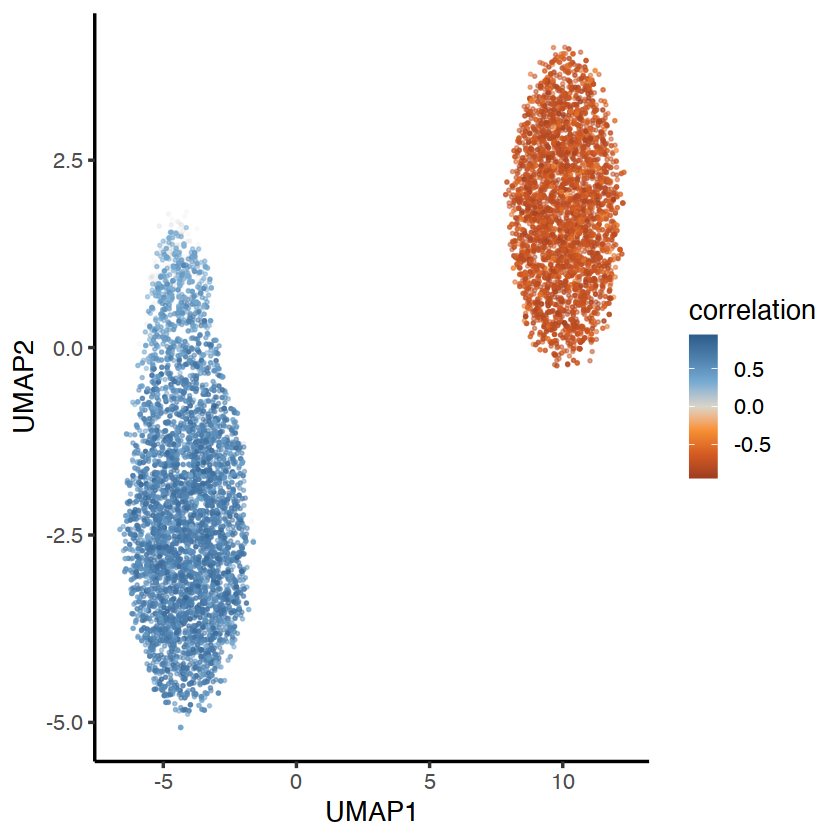

In [3]:
dimplot.ncorr(d$obsm$umap, res)

In the plot above, each cell is colored according to its neighborhood coefficient. I.e., color corresponds to the correlation of each cell's corresponding neighborhood to case/control status. Neighborhoods that don't pass FDR 5% are shown in gray. As this plot shows, cases have a greater abundance of cells from the left-hand cluster relative to controls.

Let's next perform an association test for male/female sex rather than case/control status...

In [4]:
# perform association test for male/female sex, controlling for case/control status as a covariate and accounting for potential batch effect
res <- association(data = d, y = d$samplem$male, covs='case', batches='batch')


Build NAM PCs

stopping after 4 steps

throwing out neighborhoods with batch kurtosis >= 6

keeping 10000 neighborhoods



	with ridge 1e+05, median batch kurtosis = 1.97757352884474


Perform association testing

Warning message in .association(NAMsvd = list(nam_res$NAM_sampleXpc, nam_res$NAM_svs, :
“global association p-value attained minimal possible value. Consider increasing Nnull”
computing neighborhood-level FDRs



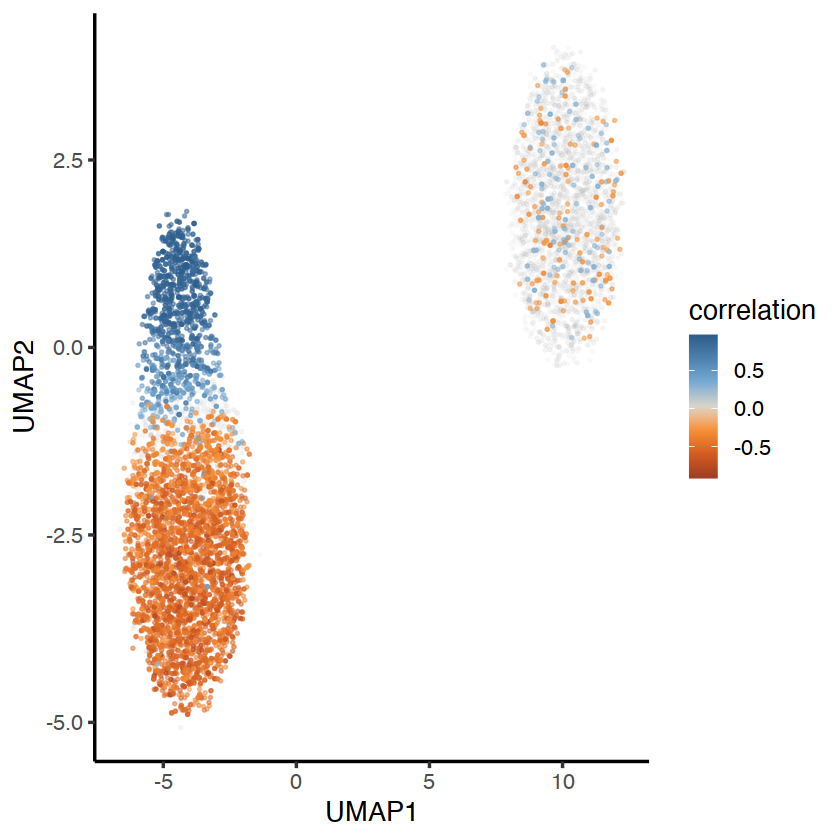

In [5]:
dimplot.ncorr(d$obsm$umap, res)

## 2. processing data into the correct format

In [6]:
## Saving this for wrapper to Seurat

## 3. additional `cna` features

### 3.1 additional results produced by `association` function

Let's re-do the `cna` analysis and go over the results in more detail

In [7]:
# perform association test for case/ctrl status, controlling for sex as a covariate and accounting for potential batch effect
res <- association(data = d, y = d$samplem$case, covs='male', batches='batch')



Build NAM PCs

stopping after 4 steps

throwing out neighborhoods with batch kurtosis >= 6

keeping 10000 neighborhoods



	with ridge 1e+05, median batch kurtosis = 1.9697975673626


Perform association testing

Warning message in .association(NAMsvd = list(nam_res$NAM_sampleXpc, nam_res$NAM_svs, :
“global association p-value attained minimal possible value. Consider increasing Nnull”
computing neighborhood-level FDRs



The `res` object returned by the association function contains the following fields:
1. `p` is the global p-value for association
1. `k` is the number of NAM PCs used for the association test (automatically selected in a data-dependent way)
1. `ncorrs` is the vector of neighborhood coefficients
1. `fdr_10p_t` and `fdr_5p_t` contain the thresholds on `np.abs(ncorrs)` needed to provide FDRs of 10% and 5% respectively
1. `fdrs` contains information on neighborhood-level FDRs at other thresholds
1. `kept` is a boolean vector that specifies which cells passed qc. So, e.g., `ncorrs` is of length `kept.sum()`.
1. `r2` is the global prediction r-squared achieved by the model
1. `r2_perpc` is the prediction r-squared achieved by each pc on its own
1. `beta` is the coefficient vector, one coefficient per PC
1. `yresid` and `yresid_hat` are the phenotype and the predicted phenotype, both with covariates and batch residualized out

The kurtosis numbers in the output above say how 'outlier-y' the neighborhood abundances are at each step in the diffusion that `cna` does to define its neighborhoods. The algorithm stops when these numbers stop going down quickly. But if you see that `cna` stops when kurtosis is still very high (like above 10), that's likely a sign that the data aren't qc'd properly or are otherwise unsuitable.

### 3.2 working directly with the NAM and NAM PCs

The association function above also automatically computes the NAM and its SVD as a prerequisite to the association testing. These can be found in the following objects
1. `d.uns['NAM.T']` contains the transpose of the NAM (neighborhoods by samples)
1. `d.uns['NAM_sampleXpc']` contains the sample loadings of the principal components of the NAM
1. `d.uns['NAM_nbhdXpc']` contains the neighborhood loadings of the principal components of the NAM
1. `d.uns['NAM_svs']` contains the squared singular values of the NAM

These objects can also be computed independent of any association test using the function `cna.tl.nam`, demonstrated below

In [8]:
#note: this NAM is being computed *without* adjusting for sex or case/ctrl status
nam_res <- nam(data = d, batches = 'batch')



stopping after 4 steps

throwing out neighborhoods with batch kurtosis >= 6

keeping 10000 neighborhoods



	with ridge 1e+05, median batch kurtosis = 1.97757352884474


Let's visualize a few of the results...

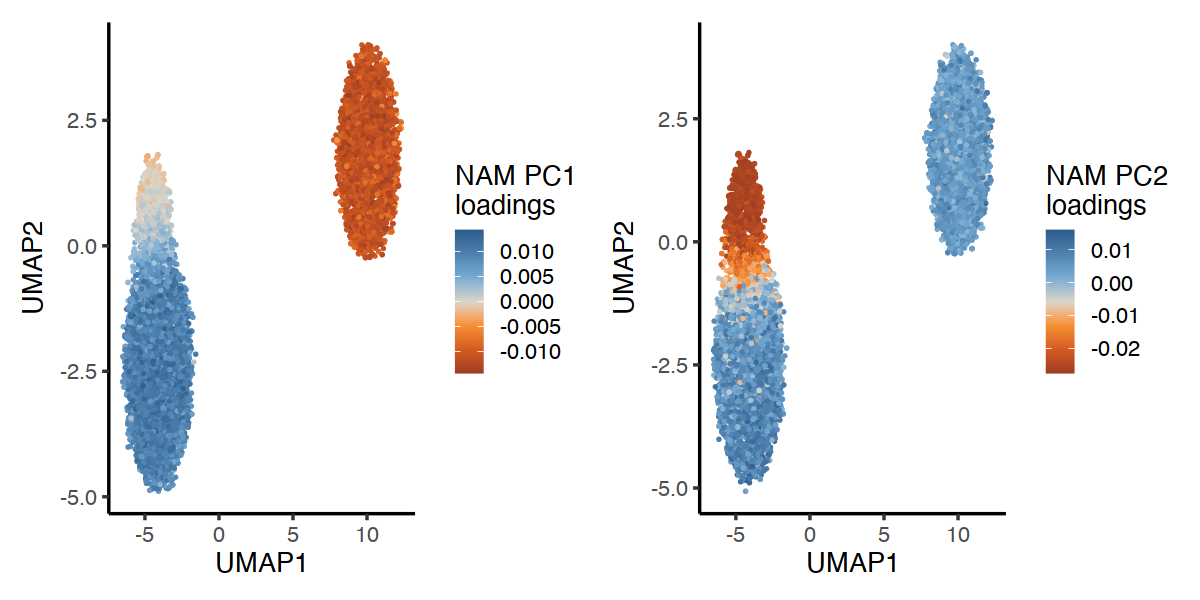

In [9]:
options(repr.plot.width=10, repr.plot.height=5)
dimplot.generic(d$obsm$umap, nam_res$NAM_nbhdXpc[, 'PC1'], 'NAM PC1\nloadings') + 
dimplot.generic(d$obsm$umap, nam_res$NAM_nbhdXpc[, 'PC2'], 'NAM PC2\nloadings') 


Joining, by = c("SampleID", "case", "male", "batch")



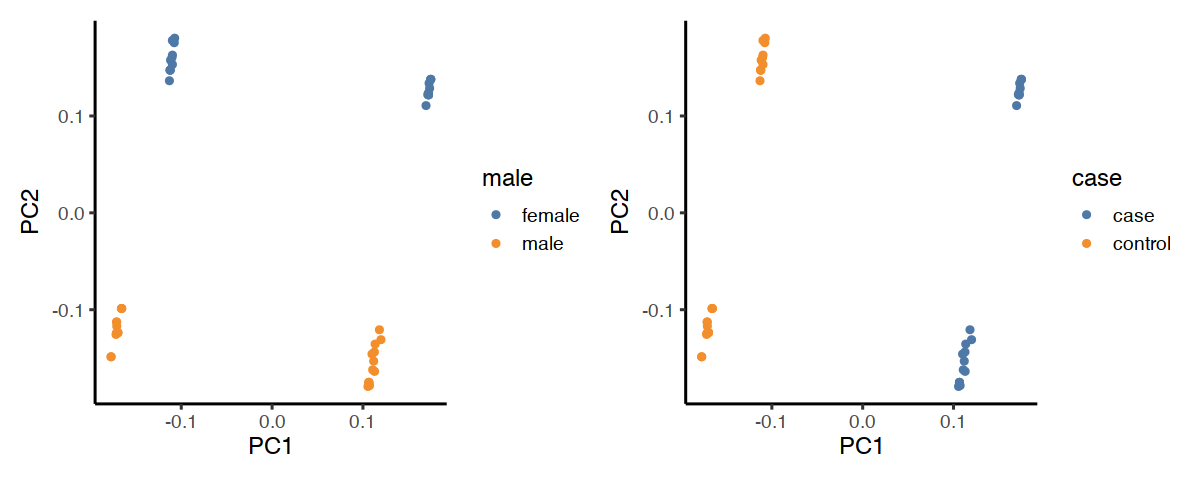

In [10]:
options(repr.plot.width=10, repr.plot.height=4)
plt <- nam_res$NAM_sampleXpc[, c(1:2)] %>% 
    cbind(d$samplem) %>% 
    dplyr::left_join(d$samplem) %>% 
    dplyr::mutate(
        male = c('female', 'male')[male + 1],
        case = c('control', 'case')[case + 1]
    ) %>% 
    dplyr::sample_frac(1L, TRUE) %>% 
    ggplot(aes(PC1, PC2)) +
        theme_classic(base_size = 14) 

plt + geom_point(aes(color = as.factor(male))) + ggthemes::scale_color_tableau() + 
    labs(color = 'male') + 
plt + geom_point(aes(color = as.factor(case))) + ggthemes::scale_color_tableau() + 
    labs(color = 'case')



You can see in these plots that NAM PC 1 roughly corresponds to case/control status and NAM PC1 roughly corresponds to sex.

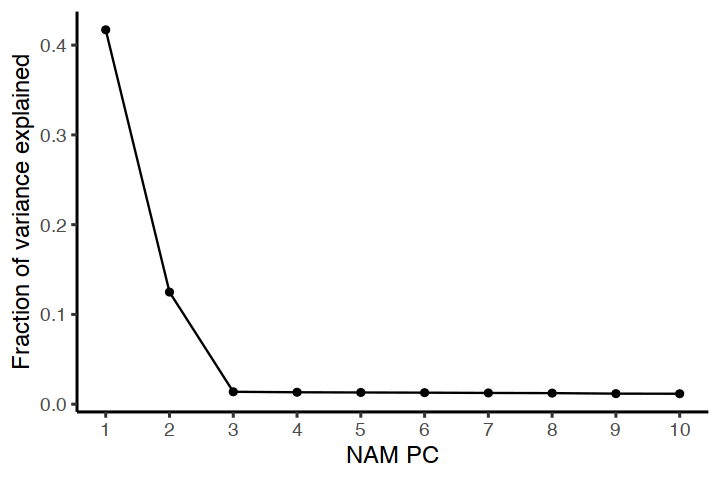

In [11]:
options(repr.plot.width=6, repr.plot.height=4)
data.frame(sig2 = nam_res$NAM_varexp) %>% 
    tibble::rowid_to_column('PC') %>% 
    ggplot(aes(PC, sig2)) + 
        geom_point() + 
        geom_line() + 
        theme_classic(base_size = 14) + 
        labs(y = 'Fraction of variance explained', x = 'NAM PC') + 
        scale_x_continuous(breaks = 1:20)

As this plot demonstrates, PC1 explains ~40% of the variance in the dataset, PC2 explains ~12%, and the rest really don't contribute much.